# **Import Required Libraries**


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



# **Load and Preprocess Data**
We drop the 'Town' and 'Address' columns, then encode the booleans as integers 1 and 0, before splitting the dataset into train-test and scaling appropriately 

In [4]:
df = pd.read_csv('../datasets/Final_ResaleData.csv')
print('Dataset shape:', df.shape)
df.head()


X = df[['Year', 'Month', 'Flat_Type', 'Storey', 'Floor_Area',
'Remaining_Lease', 'Distance_MRT', 'Distance_Mall',
'Within_1km_of_Pri', 'Mature']].copy()
y = df['Price']

# Encode booleans as integers
X['Within_1km_of_Pri'] = X['Within_1km_of_Pri'].astype(int)
X['Mature'] = X['Mature'].astype(int)

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Dataset shape: (212868, 13)


# **Feature Selection**
This section is to investigate if there are any irrelevant features that can be removed. Since neural networks can learn feature relevance internally, I will only use a simple method to remove the most irrelevant features. The methods used here will be:
- Correlation

Correlation
- It was seen that 'Flat_Type' and 'Floor_Area' were highly correlated with a score of 0.95, hence I removed 'Floor_Area' as a feature.

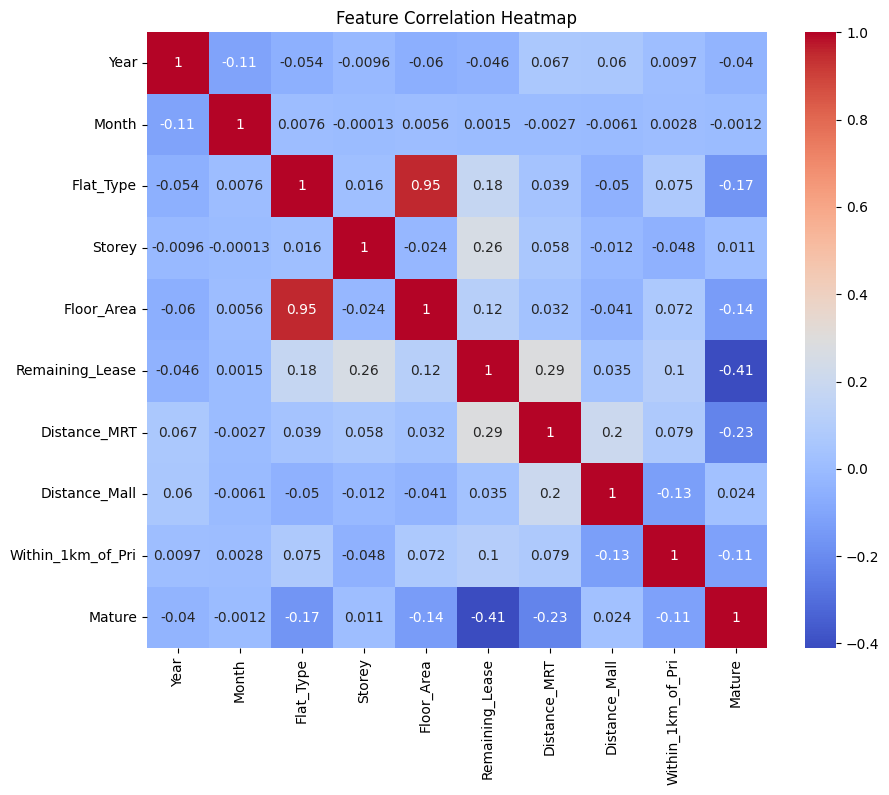

In [5]:
# **Correlation**
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


#Removal of Floor_Area due to high correlation with Flat_Type
X_train = X_train.drop(columns=['Floor_Area'])
X_val = X_val.drop(columns=['Floor_Area'])


# **Train Neural Network Model**
A neural network model is first built through a function. A pipeline is built for preprocessing and a neural network regressor. Hyperparameter fine-tuning is then carried out using HalvingGridSearchCV instead of normal GridSearchCV as the dataset is large (~213k samples). HalvingGridSearchCV provides a more efficient approach by iteratively evaluating models on increasing subsets of the data, retaining only the best-performing hyperparameter combinations in each round. This allows us to identify optimal parameters much faster while maintaining comparable accuracy.

After finetuning, here are the best hyperparameters:
- 'num_layers': 
- 'hidden units': 
- 'activation': 
- 'learning rate': 
- 'dropout rate':
- 'batch size': 


In [ ]:
def build_nn_model(
    num_layers=2,                # number of hidden layers
    hidden_units=64,             # neurons per hidden layer
    activation='relu',           # activation function
    learning_rate=0.001,         # step size for optimizer
    dropout_rate=0.2             # dropout for regularization
):     
    model = Sequential()

    # Input layer + first hidden layer
    model.add(Dense(hidden_units, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    # Additional hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(hidden_units, activation=activation))
        model.add(Dropout(dropout_rate))

    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

nn_regressor = KerasRegressor(model=build_nn_model, epochs=50, batch_size=32, verbose=0)

# Create pipeline
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', nn_regressor)
])


nn_param = {
    'nn__model__num_layers': [2, 3],
    'nn__model__hidden_units': [64, 128],
    'nn__model__activation': ['relu'],
    'nn__model__learning_rate': [0.001, 0.0005],
    'nn__model__dropout_rate': [0.1, 0.2],
    'nn__batch_size': [32, 64],
}

nn_model = HalvingGridSearchCV(
    estimator=nn_pipeline,
    param_grid=nn_param,
    factor=2,                     # halves candidate count each round
    resource='n_samples',         # increases training data progressively
    max_resources='auto',
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

nn_model.fit(X_train, y_train)

print("Best Parameters:", nn_model.best_params_)


# **Evaluate Neural Network Model**
Evaluation is carried out using RMSE, MAE and R^2 to assess prediction accuracy. The scores are as such:
- RMSE: 48945.76
- MAE: 34143.04
- R^2: 0.914

On average, the model’s resale price predictions are off by about $34k,
with larger errors (on average) around $49k.
The model explains roughly 91% of the variance in resale prices.

In [ ]:
best_nn = nn_model.best_estimator_
y_pred_nn = best_nn.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_nn))
mae = mean_absolute_error(y_val, y_pred_nn)
r2 = r2_score(y_val, y_pred_nn)

print("===== BEST NEURAL NETWORK PERFORMANCE =====")
print(f"RMSE : {rmse}")
print(f"MAE  : {mae}")
print(f"R²   : {r2}")